Ex_file.txt, Ey_file.txt, Ez_file.txt 를 업로드하세요.


Saving 4layer_V_twin_100mA_5kHz_0deg_Ex.txt to 4layer_V_twin_100mA_5kHz_0deg_Ex (1).txt
Saving 4layer_V_twin_100mA_5kHz_0deg_Ey.txt to 4layer_V_twin_100mA_5kHz_0deg_Ey (1).txt
Saving 4layer_V_twin_100mA_5kHz_0deg_Ez.txt to 4layer_V_twin_100mA_5kHz_0deg_Ez (1).txt
[Interpolator] effective-dim = 2 (varies x,y,z = [True, False, True])
자극 구간: 200.0 ms,  관찰 tail: 100.0 ms,  총 시간: 300.0 ms,  steps=60001


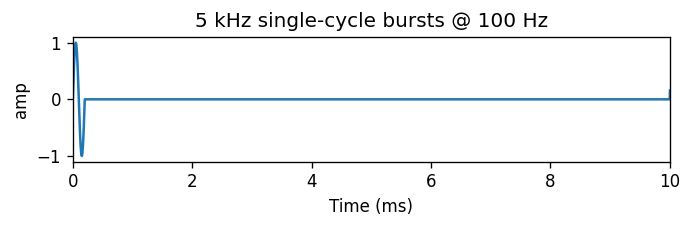

총 시간 200.0 ms, steps = 60001


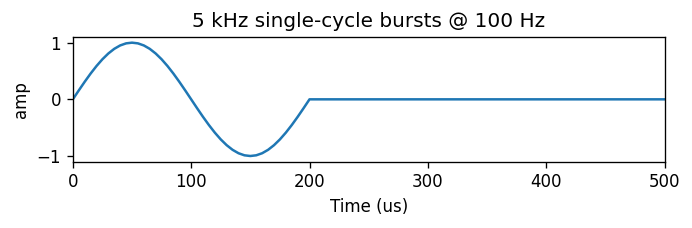

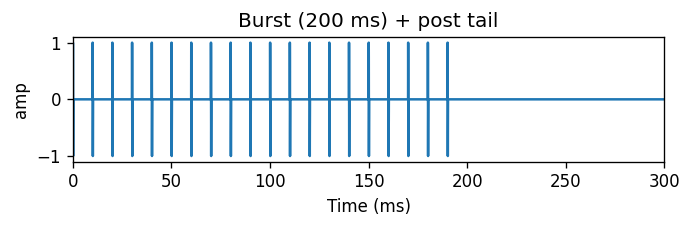

In [ ]:
# =========================
# 0) Imports & Utilities
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
from IPython.display import HTML
from google.colab import files
import io, math, re

plt.rcParams["figure.dpi"] = 120

# ---------- Upload & auto-pick Ex/Ey/Ez ----------
def upload_three_files():
    print("Ex_file.txt, Ey_file.txt, Ez_file.txt 를 업로드하세요.")
    uploaded_all = files.upload()  # 한 번에 올리면 여기서 끝
    # 필요하면 아래 주석을 풀어 추가 업로드 합칠 수 있음
    # uploaded_all.update(files.upload())

    fnames = list(uploaded_all.keys())
    if len(fnames) < 3:
        print("파일이 3개 미만입니다. 필요하면 uploaded_all.update(files.upload()) 로 합치세요.")

    fn_clean = [f.strip().replace(" ", "_").replace("(", "").replace(")", "") for f in fnames]
    name_map = dict(zip(fn_clean, fnames))

    def pick(tag):
        cand = [c for c in fn_clean if tag.lower() in c.lower()]
        if not cand:
            raise FileNotFoundError(f"'{tag}' 포함 파일을 찾지 못했습니다.\n업로드 목록: {fnames}")
        return name_map[cand[0]]

    Ex_file = pick("Ex")
    Ey_file = pick("Ey")
    Ez_file = pick("Ez")
    return uploaded_all, Ex_file, Ey_file, Ez_file

# ---------- Robust TXT/CSV parser (skip headers; x y z Re Im) ----------
def _is_numeric_row(tokens):
    try:
        for t in tokens:
            if t == "":
                continue
            float(t)
        return True
    except ValueError:
        return False

def parse_field_txt(uploaded_dict, filename, comp_tag):
    """
    헤더/설명 줄 무시하고 숫자 5개(x y z Re Im)만 추출.
    좌표가 m(절댓값 <1e-2)이면 µm로 변환.
    반환: DataFrame[x_um,y_um,z_um,<comp>_re,<comp>_im]
    """
    raw = uploaded_dict[filename].decode("utf-8", errors="ignore")
    lines = raw.splitlines()

    rows = []
    for line in lines:
        line = line.strip()
        if not line:
            continue
        line_clean = re.sub(r"[,\t]", " ", line)      # 콤마/탭 → 공백
        line_clean = re.sub(r"\s+", " ", line_clean)  # 연속 공백 축소
        toks = line_clean.split(" ")

        if _is_numeric_row(toks) and len(toks) >= 5:
            try:
                x, y, z, re_v, im_v = map(float, toks[:5])
                rows.append((x, y, z, re_v, im_v))
            except Exception:
                continue

    if not rows:
        raise ValueError(f"{filename}: 숫자 데이터 행을 찾지 못했습니다.")

    arr = np.array(rows, dtype=float)
    x, y, z, re_v, im_v = arr[:,0], arr[:,1], arr[:,2], arr[:,3], arr[:,4]

    # 단위 자동 판별 (m → µm)
    xyz_max = np.max(np.abs([x, y, z]))
    if xyz_max < 1e-2:
        x_um, y_um, z_um = x*1e6, y*1e6, z*1e6
    else:
        x_um, y_um, z_um = x, y, z

    df = pd.DataFrame({
        "x_um": x_um, "y_um": y_um, "z_um": z_um,
        f"{comp_tag}_re": re_v, f"{comp_tag}_im": im_v
    })
    return df

# ---------- Interpolator with auto-dimension fallback ----------
def build_interpolators(E_im_df, eps=1e-9):
    """
    공간 차원 자동 감지:
      - 3D: LinearNDInterpolator in (x,y,z)
      - 2D: LinearNDInterpolator in the two varying axes (e.g., x–z when y constant)
      - 1D: interp1d on the varying axis
    반환: dict(comp -> {'mode', 'proj', 'lin', 'near' or 'f1d'})
    """
    from scipy.interpolate import interp1d

    # 확실히 float로 캐스팅
    x = E_im_df["x_um"].to_numpy(dtype=float)
    y = E_im_df["y_um"].to_numpy(dtype=float)
    z = E_im_df["z_um"].to_numpy(dtype=float)

    varies = np.array([np.ptp(x) > eps, np.ptp(y) > eps, np.ptp(z) > eps])
    ndim_eff = int(varies.sum())

    interps = {}
    if ndim_eff >= 3:
        pts = E_im_df[["x_um","y_um","z_um"]].to_numpy(dtype=float)
        for comp in ["Ex_im","Ey_im","Ez_im"]:
            vals = E_im_df[comp].to_numpy(dtype=float)
            lin  = LinearNDInterpolator(pts, vals)
            near = NearestNDInterpolator(pts, vals)
            interps[comp] = {"mode":"3d", "proj":(0,1,2), "lin":lin, "near":near}

    elif ndim_eff == 2:
        axes = np.where(varies)[0]  # 예: [0,2] = (x,z)
        ax1, ax2 = int(axes[0]), int(axes[1])
        pts2 = np.column_stack([
            E_im_df[["x_um","y_um","z_um"]].to_numpy(dtype=float)[:, ax1],
            E_im_df[["x_um","y_um","z_um"]].to_numpy(dtype=float)[:, ax2],
        ])
        for comp in ["Ex_im","Ey_im","Ez_im"]:
            vals = E_im_df[comp].to_numpy(dtype=float)
            lin  = LinearNDInterpolator(pts2, vals)
            near = NearestNDInterpolator(pts2, vals)
            interps[comp] = {"mode":"2d", "proj":(ax1, ax2), "lin":lin, "near":near}

    elif ndim_eff == 1:
        axis = int(np.where(varies)[0][0])
        coord = E_im_df[["x_um","y_um","z_um"]].to_numpy(dtype=float)[:, axis]
        order = np.argsort(coord)
        coord = coord[order]
        for comp in ["Ex_im","Ey_im","Ez_im"]:
            vals = E_im_df[comp].to_numpy(dtype=float)[order]
            f1d  = interp1d(coord, vals, kind="linear", fill_value="extrapolate", assume_sorted=True)
            interps[comp] = {"mode":"1d", "proj":(axis,), "f1d":f1d}
    else:
        raise ValueError("모든 좌표 축이 상수입니다. (단일 포인트만 존재)")

    interps["_meta"] = {"ndim_eff": ndim_eff, "varies": varies.tolist()}
    print(f"[Interpolator] effective-dim = {ndim_eff} (varies x,y,z = {varies.tolist()})")
    return interps

def interp_val(interps, name, r3):
    info = interps[name]
    mode = info["mode"]
    if mode == "3d":
        lin, near = info["lin"], info["near"]
        v = lin(*r3)
        if v is None or (isinstance(v, float) and math.isnan(v)):
            v = near(*r3)
        return float(v)
    elif mode == "2d":
        ax1, ax2 = info["proj"]
        p = np.array([r3[ax1], r3[ax2]], dtype=float)
        lin, near = info["lin"], info["near"]
        v = lin(*p)
        if v is None or (isinstance(v, float) and math.isnan(v)):
            v = near(*p)
        return float(v)
    elif mode == "1d":
        axis = info["proj"][0]
        return float(info["f1d"](r3[axis]))
    else:
        raise RuntimeError("Unknown interpolation mode")

# ---------- Path & integration ----------
def make_straight_path(anchor_um, length_um, step_um, direction_vec):
    d = np.array(direction_vec, dtype=float); d /= np.linalg.norm(d)
    nseg = int(np.round(length_um/step_um)) + 1
    s = np.linspace(0.0, length_um, nseg)
    xyz = anchor_um[None,:] + s[:,None]*d[None,:]
    seg = np.diff(xyz, axis=0)
    ds  = np.linalg.norm(seg, axis=1)
    ds  = np.concatenate([[0.0], ds])
    tan = np.zeros_like(xyz)
    tan[1:-1] = xyz[2:] - xyz[:-2]
    tan[0]    = xyz[1] - xyz[0]
    tan[-1]   = xyz[-1] - xyz[-2]
    tn = np.linalg.norm(tan, axis=1, keepdims=True); tn[tn==0] = 1.0
    that = tan/tn
    return xyz, ds, that

def compute_Epar_amp_90deg(interps, xyz, that, scale_E=1.0): #phase 0 deg에서 complex 추출 후, -Img (90deg) 계산
    Epar_amp = np.zeros(len(xyz))
    for i, r in enumerate(xyz):
        E90 = np.array([
            -interp_val(interps, "Ex_im", r),
            -interp_val(interps, "Ey_im", r),
            -interp_val(interps, "Ez_im", r)
        ]) * scale_E
        Epar_amp[i] = np.dot(E90, that[i,:])  # V/m
    return Epar_amp

def build_burst_waveform(f_carrier_hz, pulse_on_ms, pulse_off_ms, repeats, dt_ms):
    period = pulse_on_ms + pulse_off_ms
    tstop  = period * repeats
    t_ms   = np.arange(0, tstop + dt_ms, dt_ms)
    w      = 2*np.pi*f_carrier_hz
    carrier= np.sin(w*(t_ms/1000.0))
    #carrier = -np.sin(w*(t_ms/1000.0)) #for cathodic first waveform
    gate   = (np.mod(t_ms, period) < pulse_on_ms).astype(float)
    wave   = carrier * gate
    return t_ms, wave, period, tstop

def Epar_to_Ve(Epar_amp, wave, ds):
    Epar_t = np.outer(Epar_amp, wave)               # (Nseg, Nt) V/m
    Ve = -np.cumsum((Epar_t.T * ds).T, axis=0) * 1e-6  # µm→m
    Ve = Ve - Ve[0:1,:]
    return Ve

def save_ve_csv(Ve, t_ms, out_name):
    # Ve: (Nseg, Nt) -> (Nt, Nseg)로 전치해 '시간이 행'이 되게 저장
    df_out = pd.DataFrame(Ve.T, columns=[f"seg_{i}" for i in range(Ve.shape[0])])
    df_out.insert(0, "t_ms", t_ms)
    df_out.to_csv(out_name, index=False)
    try:
        from google.colab import files
        files.download(out_name)
    except:
        pass
    print(f"Saved: {out_name}  (rows={df_out.shape[0]}=Nt, cols={df_out.shape[1]}=1+Nseg)")

def animate_three_neurons(all_Ve, t_ms, title="Ve(t) along 3 pyramidal neurons"):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    vmax = max(np.abs(Ve).max() for _,Ve in all_Ve)
    scatters = []
    for xyz, Ve in all_Ve:
        sc = ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2],
                        c=Ve[:,0], cmap='coolwarm', s=20,
                        vmin=-vmax, vmax=vmax)
        scatters.append(sc)
    ax.set_xlabel('x (µm)'); ax.set_ylabel('y (µm)'); ax.set_zlabel('z (µm)')
    ax.set_title(title); ax.set_box_aspect([1,1,2]); ax.view_init(elev=20, azim=40)

    def update(frame):
        for sc, (_,Ve) in zip(scatters, all_Ve):
            sc.set_array(Ve[:,frame])
        ax.set_title(f"{title} | t = {t_ms[frame]:.3f} ms")
        return scatters

    ani = animation.FuncAnimation(fig, update, frames=len(t_ms), interval=30, blit=False)
    plt.close(fig)
    return HTML(ani.to_jshtml())

# =========================
# 1) User params
# =========================
F_CARRIER_HZ = 5_000.0
PULSE_ON_MS  = 0.2      # 5 kHz 한 주기
PULSE_OFF_MS = 9.8      # 100 Hz 반복
REPEATS      = 20       # cycle
DT_MS        = 0.005

L_UM     = 600.0
STEP_UM  = 5.0
DIR_VEC  = np.array([0.0, 0.0, 1.0])  # z-axis for PN
ANCHORS  = [
    np.array([-60.0, 40.0, -910.0]),
    np.array([  0.0, 40.0, -910.0]),
    np.array([ 60.0, 40.0, -910.0]),
]
SCALE_E  = 1.0

# =========================
# 2) Upload & Parse
# =========================
uploaded_all, Ex_file, Ey_file, Ez_file = upload_three_files()
Ex_df_raw = parse_field_txt(uploaded_all, Ex_file, "Ex")
Ey_df_raw = parse_field_txt(uploaded_all, Ey_file, "Ey")
Ez_df_raw = parse_field_txt(uploaded_all, Ez_file, "Ez")

assert len(Ex_df_raw)==len(Ey_df_raw)==len(Ez_df_raw), "E-field 세 파일의 행 수가 다릅니다!"

# 허수부만 통합 → 숫자형 강제 변환
E_im_df = pd.DataFrame({
    "x_um":  Ex_df_raw["x_um"],
    "y_um":  Ex_df_raw["y_um"],
    "z_um":  Ex_df_raw["z_um"],
    "Ex_im": Ex_df_raw["Ex_im"],
    "Ey_im": Ey_df_raw["Ey_im"],
    "Ez_im": Ez_df_raw["Ez_im"],
})
for col in ["x_um","y_um","z_um","Ex_im","Ey_im","Ez_im"]:
    E_im_df[col] = pd.to_numeric(E_im_df[col], errors="coerce")
bad = E_im_df.isna().any()
if bad.any():
    raise ValueError(f"Non-numeric values detected after parsing: {bad.to_dict()}")

# =========================
# 3) Interpolators (auto 3D/2D/1D)
# =========================
interps = build_interpolators(E_im_df)

# =========================
# 4) Burst waveform
# =========================
t_ms, wave, period, tstop = build_burst_waveform(F_CARRIER_HZ, PULSE_ON_MS, PULSE_OFF_MS, REPEATS, DT_MS)
POST_TAIL_MS = 100.0

n_tail = int(np.round(POST_TAIL_MS / DT_MS))
tail_t = t_ms[-1] + np.arange(1, n_tail+1) * DT_MS
tail_w = np.zeros_like(tail_t)

# 시간/파형 이어 붙이기
t_ms = np.concatenate([t_ms, tail_t])
wave = np.concatenate([wave, tail_w])

print(f"자극 구간: {REPEATS*(PULSE_ON_MS+PULSE_OFF_MS):.1f} ms,  "
      f"관찰 tail: {POST_TAIL_MS:.1f} ms,  총 시간: {t_ms[-1]:.1f} ms,  steps={len(t_ms)}")



plt.figure(figsize=(6,2)); plt.plot(t_ms, wave); plt.xlim(0,10)
plt.title("5 kHz single-cycle bursts @ 100 Hz"); plt.xlabel("Time (ms)"); plt.ylabel("amp")
plt.tight_layout(); plt.show()

t_us = t_ms * 1e3
print(f"총 시간 {tstop:.1f} ms, steps = {len(t_ms)}")
plt.figure(figsize=(6,2)); plt.plot(t_us, wave); plt.xlim(0,500)
plt.title("5 kHz single-cycle bursts @ 100 Hz"); plt.xlabel("Time (us)"); plt.ylabel("amp")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,2))
plt.plot(t_ms, wave)
plt.xlim(0, t_ms[-1])
plt.xlabel("Time (ms)"); plt.ylabel("amp")
plt.title("Burst (200 ms) + post tail")
plt.tight_layout(); plt.show()


In [ ]:
# =========================
# 5) Paths → Ve(t) → Save
# =========================
all_Ve = []
for i, anchor in enumerate(ANCHORS, start=1):
    xyz, ds, that = make_straight_path(anchor, L_UM, STEP_UM, DIR_VEC)
    Epar_amp = compute_Epar_amp_90deg(interps, xyz, that, SCALE_E)
    Ve = Epar_to_Ve(Epar_amp, wave, ds)
    all_Ve.append((xyz, Ve))
    #save_ve_csv(Ve, t_ms, f"Ve_time_series_2Ocycle_post100ms_0deg_{i}.csv")



In [ ]:
print(len(all_Ve), [Ve.shape for _, Ve in all_Ve])

3 [(121, 60001), (121, 60001), (121, 60001)]


In [ ]:
print(len(t_ms), len(wave))
print("t_ms max =", t_ms.max())

60001 60001
t_ms max = 300.0


In [ ]:
for i,(xyz,Ve) in enumerate(all_Ve, start=1):
    print(f"Neuron {i}: Ve min={Ve.min():.3e} V, max={Ve.max():.3e} V, "
          f"rms(on-window)={np.sqrt(np.mean(Ve[:, wave>0]**2)):.3e} V")

Neuron 1: Ve min=-7.276e-07 V, max=7.276e-07 V, rms(on-window)=3.265e-07 V
Neuron 2: Ve min=-3.549e-06 V, max=3.549e-06 V, rms(on-window)=1.466e-06 V
Neuron 3: Ve min=-6.744e-07 V, max=6.744e-07 V, rms(on-window)=2.992e-07 V


In [ ]:
# =========================
# 6) Animation
# =========================
animate_three_neurons(all_Ve, t_ms, title="Ve(t) along 3 pyramidal neurons (z-axis)")

KeyboardInterrupt: 

[Grid] x[-200.0, 200.0] µm Δx≈10.000, z[-1500.0, 1500.0] µm Δz≈10.000
[Grid] x[-200.0, 200.0] µm Δx≈10.000, z[-1500.0, 1500.0] µm Δz≈10.000


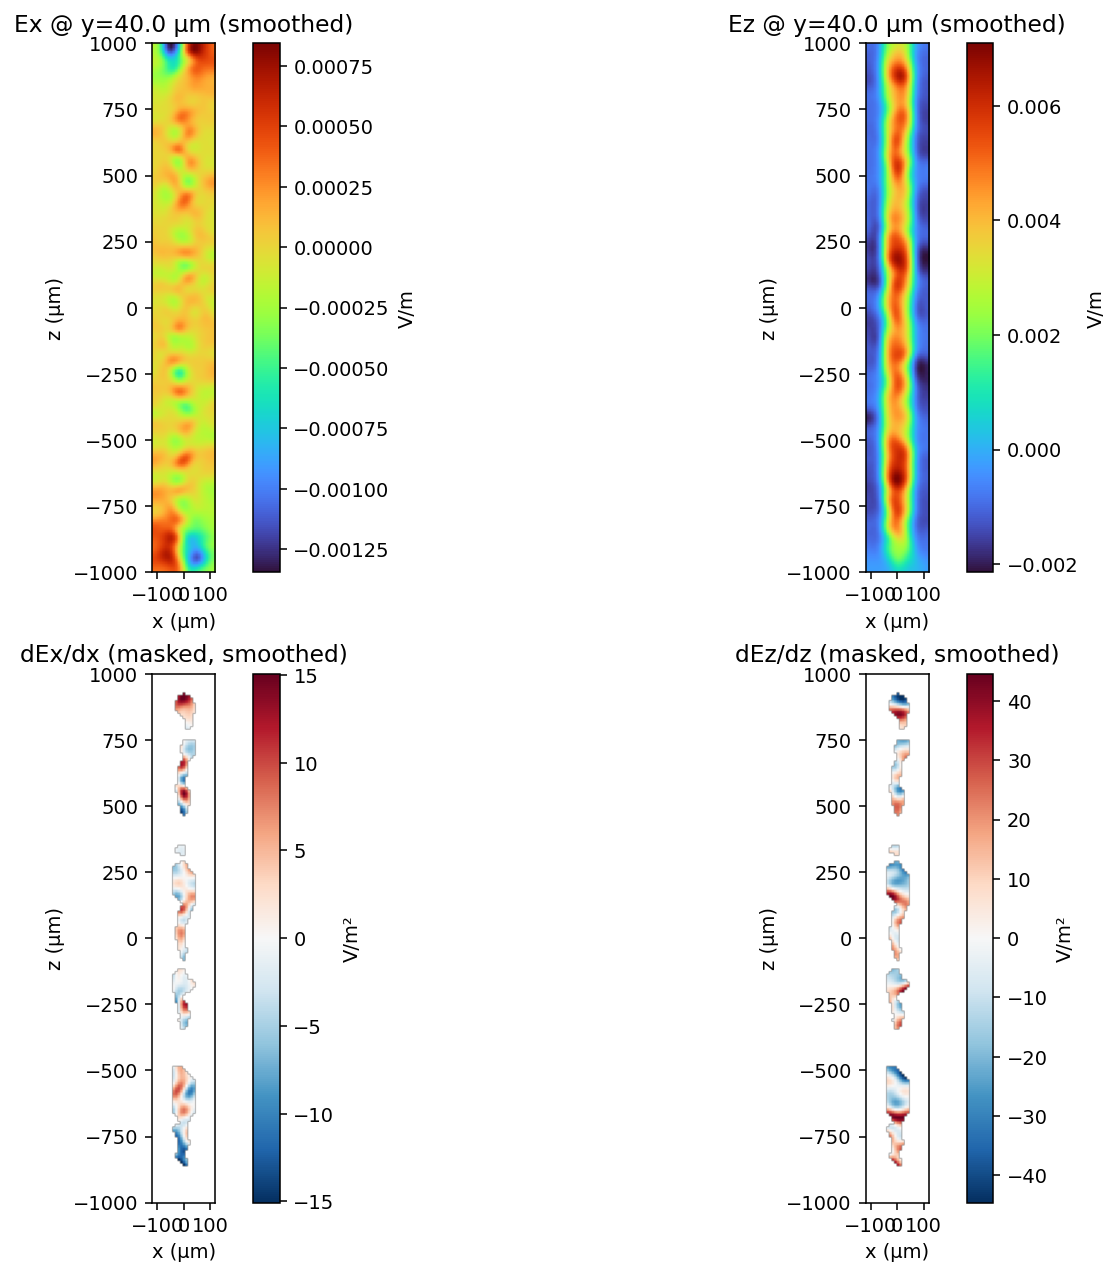

In [ ]:
# =========================
# 6) Ex/Ey/Ez (Imag) 히트맵 & Ve(z,t*) 히트맵
# =========================

# --- 6-1) Ex/Ez, Fx/Fz -------------------------
from scipy.ndimage import gaussian_filter

# --- 설정값만 상황에 맞게 조절 ---
FIELD_SOURCE = "imag90"   # "imag90"(-Imag=90° 위상), "real"(스칼라 re), "mag"(진폭)
Y_PICK       = "auto"      # "auto"면 최빈 y 평면, 숫자면 해당 y(µm)
ROI_XLIM     = (-120, 120) # µm
ROI_ZLIM     = (-1000, 1000)# µm
SIGMA_SMOOTH = 2.0         # 가우시안 스무딩(픽셀)
MASK_Q       = 0.85        # |Ez| 상위 구간만 남겨 미분 노이즈 억제(0.85~0.95 권장)
CMAP_FIELD   = "turbo"     # 필드용(노랑=최대)
CMAP_GRAD    = "RdBu_r"    # 그래디언트용(빨강=양, 파랑=음)

# ---- 5.1 결합 DF 만들기(업로드/파싱 완료본 재사용) ----
E_df = pd.DataFrame({
    "x_um": Ex_df_raw["x_um"].astype(float),
    "y_um": Ex_df_raw["y_um"].astype(float),
    "z_um": Ex_df_raw["z_um"].astype(float),
    "Ex_re": Ex_df_raw["Ex_re"].astype(float),
    "Ex_im": Ex_df_raw["Ex_im"].astype(float),
    "Ey_re": Ey_df_raw["Ey_re"].astype(float),
    "Ey_im": Ey_df_raw["Ey_im"].astype(float),
    "Ez_re": Ez_df_raw["Ez_re"].astype(float),
    "Ez_im": Ez_df_raw["Ez_im"].astype(float),
})

def _pick_y_slice(df, y_pick="auto", atol=1e-3):
    if y_pick == "auto":
        y_mode = df["y_um"].round(6).mode()[0]
        m = np.isclose(df["y_um"], y_mode, atol=atol)
        return df[m].copy(), float(y_mode)
    else:
        yv = float(y_pick)
        m = np.isclose(df["y_um"], yv, atol=atol)
        return df[m].copy(), yv

def _materialize(df, base, src):
    if src == "imag90":   # 90° 성분(−Imag)
        return -(df[f"{base}_im"].to_numpy(float))
    if src == "real":     # 스칼라(real)
        return df[f"{base}_re"].to_numpy(float)
    if src == "mag":      # 크기
        re = df[f"{base}_re"].to_numpy(float)
        im = df[f"{base}_im"].to_numpy(float)
        return np.hypot(re, im)
    raise ValueError("FIELD_SOURCE must be 'imag90' | 'real' | 'mag'")

def _gridify_xz(df_slice, vals, round_nd=6):
    d = df_slice.copy()
    d["x_r"] = d["x_um"].round(round_nd)
    d["z_r"] = d["z_um"].round(round_nd)
    Xs = np.sort(d["x_r"].unique())
    Zs = np.sort(d["z_r"].unique())
    piv = (d.assign(val=vals)
             .pivot_table(index="z_r", columns="x_r", values="val")
             .reindex(index=Zs, columns=Xs))
    G = piv.to_numpy()
    dx_um = float(np.mean(np.diff(Xs)))
    dz_um = float(np.mean(np.diff(Zs)))
    print(f"[Grid] x[{Xs[0]}, {Xs[-1]}] µm Δx≈{dx_um:.3f}, z[{Zs[0]}, {Zs[-1]}] µm Δz≈{dz_um:.3f}")
    return Xs, Zs, G, dx_um, dz_um

def _crop_roi(Xs, Zs, G, xlim, zlim):
    ix = np.where((Xs >= xlim[0]) & (Xs <= xlim[1]))[0]
    iz = np.where((Zs >= zlim[0]) & (Zs <= zlim[1]))[0]
    return Xs[ix], Zs[iz], G[np.ix_(iz, ix)]

def _grad_x(G, dx_m):
    gy, gx = np.gradient(G, dz_m, dx_m)  # (d/dz, d/dx)
    return gx

def _grad_z(G, dz_m):
    gy, gx = np.gradient(G, dz_m, dx_m)
    return gy

def _sym_vlim(A, q=0.995):
    vmax = np.nanquantile(np.abs(A), q)
    return -vmax, vmax

# ---- 5.2 단일 y-슬라이스 선택 & 그리드화 ----
E_slice, y_used = _pick_y_slice(E_df, Y_PICK)
Ex_vals = _materialize(E_slice, "Ex", FIELD_SOURCE)
Ez_vals = _materialize(E_slice, "Ez", FIELD_SOURCE)

Xs, Zs, Ex_grid, dx_um, dz_um = _gridify_xz(E_slice, Ex_vals)
_,  _,  Ez_grid, _,     _      = _gridify_xz(E_slice, Ez_vals)

dx_m, dz_m = dx_um*1e-6, dz_um*1e-6

# ---- 5.3 ROI 자르고 스무딩/마스크/미분 ----
XsR, ZsR, ExR = _crop_roi(Xs, Zs, Ex_grid, ROI_XLIM, ROI_ZLIM)
_,   _,   EzR = _crop_roi(Xs, Zs, Ez_grid, ROI_XLIM, ROI_ZLIM)

ExS = gaussian_filter(ExR, SIGMA_SMOOTH)
EzS = gaussian_filter(EzR, SIGMA_SMOOTH)

Ez_amp = gaussian_filter(np.abs(EzR), 1.0)
thr = np.quantile(Ez_amp, MASK_Q)
mask = Ez_amp >= thr

dExdx = _grad_x(ExS, dx_m)
dEzdz = _grad_z(EzS, dz_m)

dExdx_m = np.where(mask, dExdx, np.nan)
dEzdz_m = np.where(mask, dEzdz, np.nan)

# ---- 5.4 플롯(4패널) ----
fig, ax = plt.subplots(2, 2, figsize=(10, 9), constrained_layout=True)

# Ex
im = ax[0,0].imshow(ExS, extent=[XsR[0], XsR[-1], ZsR[0], ZsR[-1]],
                    origin="lower", aspect="equal", cmap=CMAP_FIELD)
plt.colorbar(im, ax=ax[0,0]).set_label("V/m")
ax[0,0].set_title(f"Ex @ y={y_used:.1f} µm (smoothed)")
ax[0,0].set_xlabel("x (µm)"); ax[0,0].set_ylabel("z (µm)")

# Ez
im = ax[0,1].imshow(EzS, extent=[XsR[0], XsR[-1], ZsR[0], ZsR[-1]],
                    origin="lower", aspect="equal", cmap=CMAP_FIELD)
plt.colorbar(im, ax=ax[0,1]).set_label("V/m")
ax[0,1].set_title(f"Ez @ y={y_used:.1f} µm (smoothed)")
ax[0,1].set_xlabel("x (µm)"); ax[0,1].set_ylabel("z (µm)")

# dEx/dx
vmin, vmax = _sym_vlim(dExdx_m)
im = ax[1,0].imshow(dExdx_m, extent=[XsR[0], XsR[-1], ZsR[0], ZsR[-1]],
                    origin="lower", aspect="equal", cmap=CMAP_GRAD, vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax[1,0]).set_label("V/m²")
ax[1,0].set_title("dEx/dx (masked, smoothed)")
ax[1,0].set_xlabel("x (µm)"); ax[1,0].set_ylabel("z (µm)")

# dEz/dz
vmin, vmax = _sym_vlim(dEzdz_m)
im = ax[1,1].imshow(dEzdz_m, extent=[XsR[0], XsR[-1], ZsR[0], ZsR[-1]],
                    origin="lower", aspect="equal", cmap=CMAP_GRAD, vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax[1,1]).set_label("V/m²")
ax[1,1].set_title("dEz/dz (masked, smoothed)")
ax[1,1].set_xlabel("x (µm)"); ax[1,1].set_ylabel("z (µm)")

plt.show()

In [ ]:
def crop_roi(Xs, Zs, A, xlim=None, zlim=None):
    """Xs,Zs는 1D 축(균일), A는 (Nz,Nx) 그리드.
       xlim, zlim에 해당하는 슬라이스 반환."""
    ix = slice(None); iz = slice(None)
    if xlim is not None:
        ix = slice(np.searchsorted(Xs, xlim[0]), np.searchsorted(Xs, xlim[1])+1)
    if zlim is not None:
        iz = slice(np.searchsorted(Zs, zlim[0]), np.searchsorted(Zs, zlim[1])+1)
    return Xs[ix], Zs[iz], A[iz, ix]

def robust_grad_z(A, dz_m):
    """중심차분으로 z미분. 경계는 NaN으로 처리해 테두리 아티팩트를 숨김."""
    dA = np.full_like(A, np.nan, dtype=float)
    dA[1:-1,:] = (A[2:,:] - A[:-2,:]) / (2*dz_m)
    return dA

def robust_grad_x(A, dx_m):
    dA = np.full_like(A, np.nan, dtype=float)
    dA[:,1:-1] = (A[:,2:] - A[:,:-2]) / (2*dx_m)
    return dA
# Xs, Zs  : 1D 축 (µm)
# Ex_grid, Ez_grid : (Nz, Nx)
dx_um = np.mean(np.diff(Xs)); dz_um = np.mean(np.diff(Zs))
dx_m, dz_m = dx_um*1e-6, dz_um*1e-6

# === 1) ROI 크롭 (팁 주변만) ===
xlim = (-120, 120)    # 필요에 맞춰 조정
zlim = (-1000, 1000)
Xs_roi, Zs_roi, Ez_roi = crop_roi(Xs, Zs, Ez_grid, xlim, zlim)

# === 2) 아주 작은 |Ez| 구간은 마스크로 제거 (수치미분 노이즈 억제) ===
Ez_amp = gaussian_filter(np.abs(Ez_roi), sigma=1.0)     # 약한 프리-스무딩
thr = np.quantile(Ez_amp, 0.85)                         # 상위 15%만 남김(가변)
mask = Ez_amp >= thr

# === 3) 강한 스무딩 후 미분 (or 미분 후 재스무딩, 둘 다 시도 가능) ===
Ez_s = gaussian_filter(Ez_roi, sigma=2.0)               # MATLAB의 imgaussfilt(2)에 대응
dEz_dz = robust_grad_z(Ez_s, dz_m)

# 마스크 적용: 관심 아닌 곳은 NaN으로 날려 보이기만 숨김
dEz_dz_masked = np.where(mask, dEz_dz, np.nan)

# === 4) 컬러 범위는 강하게 클리핑 (낮은 신호·잔상 억제) ===
vmax = np.nanquantile(np.abs(dEz_dz_masked), 0.995)     # 최상위 0.5% 제외
vmin = -vmax

# === 5) 플롯 ===
plt.figure(figsize=(6,5))
im = plt.imshow(dEz_dz_masked, extent=[Xs_roi[0], Xs_roi[-1], Zs_roi[0], Zs_roi[-1]],
                origin='lower', aspect='equal', cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar(im, label="V/m²")
plt.title("dEz/dz (ROI, masked, smoothed)")
plt.xlabel("x (µm)"); plt.ylabel("z (µm)")
plt.tight_layout(); plt.show()

Xs_roi, Zs_roi, Ex_roi = crop_roi(Xs, Zs, Ex_grid, xlim, zlim)
Ex_amp = gaussian_filter(np.abs(Ex_roi), 1.0)
mask_x = Ex_amp >= np.quantile(Ex_amp, 0.85)
Ex_s = gaussian_filter(Ex_roi, 2.0)
dEx_dx = robust_grad_x(Ex_s, dx_m)
dEx_dx_masked = np.where(mask_x, dEx_dx, np.nan)
vmax = np.nanquantile(np.abs(dEx_dx_masked), 0.995); vmin = -vmax

plt.figure(figsize=(6,5))
im = plt.imshow(dEx_dx_masked, extent=[Xs_roi[0], Xs_roi[-1], Zs_roi[0], Zs_roi[-1]],
                origin='lower', aspect='equal', cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar(im, label="V/m²")
plt.title("dEx/dx (ROI, masked, smoothed)")
plt.xlabel("x (µm)"); plt.ylabel("z (µm)")
plt.tight_layout(); plt.show()


NameError: name 'Ez_grid' is not defined

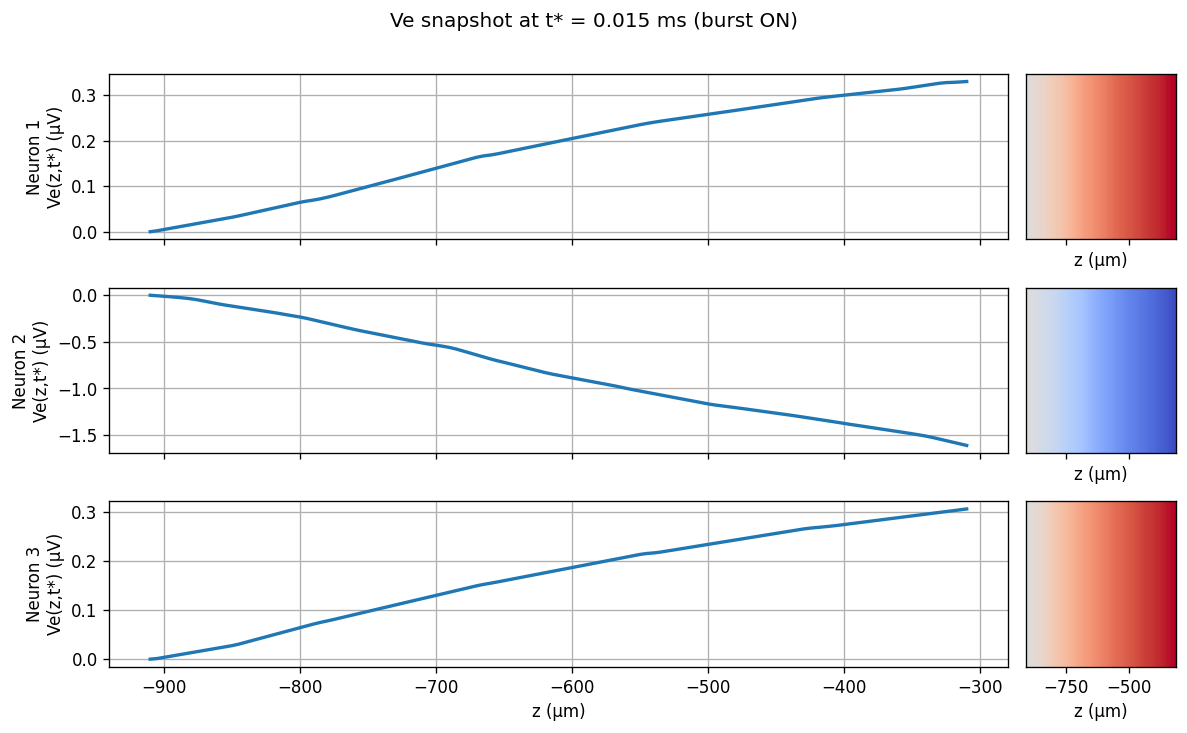

t* index = 3,  t* = 0.015 ms


In [ ]:
# --- 6-2) 특정 시간 t*에서 Ve(z,t*) 히트맵 (3개 뉴런) -----------
# t* 선택: on 구간(게이트 켜짐)에서 몇 프레임 뒤
on_idx = np.where(wave > 0)[0]
if len(on_idx) == 0:
    raise RuntimeError("burst on 구간이 없습니다. PULSE_ON_MS/REPEATS 설정을 확인하세요.")
t_idx = int(on_idx[0] + 2)   # on 시작 직후 프레임(원하면 숫자 바꿔도 됨)

def plot_Ve_snapshot_heatmaps(all_Ve, t_ms, t_idx):
    fig, axes = plt.subplots(3, 2, figsize=(10, 6),
                             gridspec_kw={"width_ratios":[6,1]}, sharex='col')

    for i, (xyz, Ve) in enumerate(all_Ve, start=1):
        z = xyz[:, 2]
        Ve_snap = Ve[:, t_idx]            # [V]
        # (좌) 곡선
        ax = axes[i-1, 0]
        ax.plot(z, Ve_snap*1e6, lw=2)
        ax.grid(True)
        ax.set_ylabel(f"Neuron {i}\nVe(z,t*) (µV)")
        # (우) 1×N 히트맵(같은 데이터)
        axh = axes[i-1, 1]
        v = _p99_sym(Ve_snap)
        axh.imshow(Ve_snap[None, :], aspect="auto", cmap="coolwarm",
                   vmin=-v, vmax=v, extent=[z.min(), z.max(), 0, 1])
        axh.set_yticks([]); axh.set_xlabel("z (µm)")

    axes[-1, 0].set_xlabel("z (µm)")
    plt.suptitle(f"Ve snapshot at t* = {t_ms[t_idx]:.3f} ms (burst ON)", y=1.01)
    plt.tight_layout(); plt.show()

plot_Ve_snapshot_heatmaps(all_Ve, t_ms, t_idx)
print(f"t* index = {t_idx},  t* = {t_ms[t_idx]:.3f} ms")

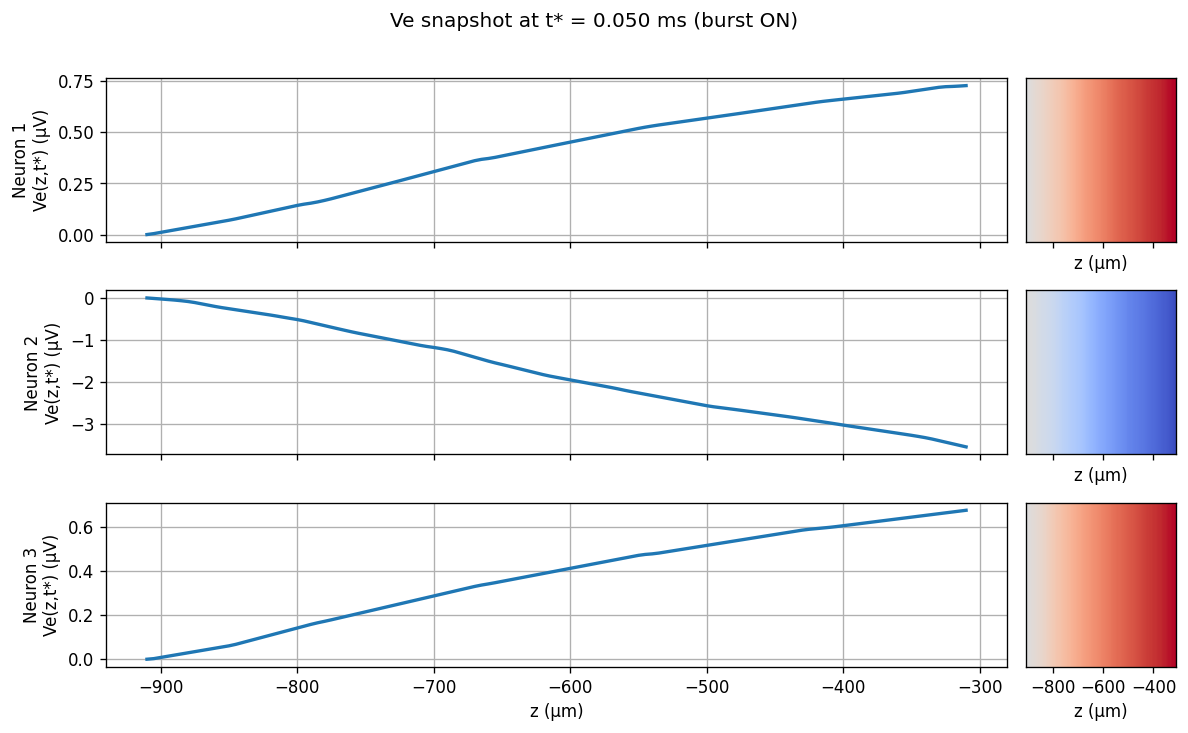

Neuron 1: Ve(t*=0.050 ms) → min = 0.000 µV, max = 0.728 µV, Δ = 0.728 µV
Neuron 2: Ve(t*=0.050 ms) → min = -3.549 µV, max = 0.000 µV, Δ = 3.549 µV
Neuron 3: Ve(t*=0.050 ms) → min = 0.000 µV, max = 0.674 µV, Δ = 0.674 µV


In [ ]:
def nearest_idx(t_array_ms, t_target_ms):
    return int(np.argmin(np.abs(t_array_ms - t_target_ms)))

t_idx_Emax1 = nearest_idx(t_ms, 0.05)   # E 최대(1)


# 예: E가 최대인 순간을 찍어보려면
plot_Ve_snapshot_heatmaps(all_Ve, t_ms, t_idx_Emax1)
for i, (xyz, Ve) in enumerate(all_Ve, start=1):
        Ve_snap = Ve[:, t_idx_Emax1]
        vmax = np.max(Ve_snap)
        vmin = np.min(Ve_snap)
        print(f"Neuron {i}: Ve(t*={t_ms[t_idx_Emax1]:.3f} ms) → "
              f"min = {vmin*1e6:.3f} µV, max = {vmax*1e6:.3f} µV, "
              f"Δ = {(vmax-vmin)*1e6:.3f} µV")


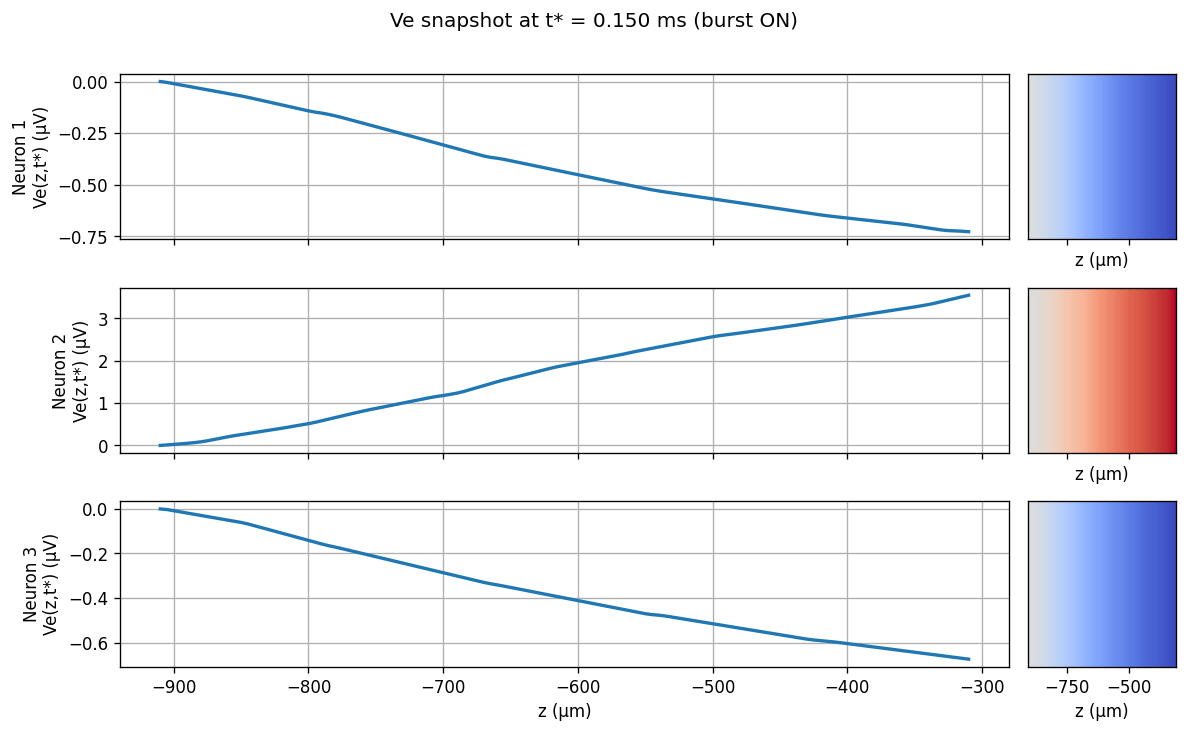

Neuron 1: Ve(t*=0.150 ms) → min = -0.728 µV, max = 0.000 µV, Δ = 0.728 µV
Neuron 2: Ve(t*=0.150 ms) → min = 0.000 µV, max = 3.549 µV, Δ = 3.549 µV
Neuron 3: Ve(t*=0.150 ms) → min = -0.674 µV, max = 0.000 µV, Δ = 0.674 µV


In [ ]:
def nearest_idx(t_array_ms, t_target_ms):
    return int(np.argmin(np.abs(t_array_ms - t_target_ms)))

t_idx_Emax2 = nearest_idx(t_ms, 0.15)   # E 최대(2)

plot_Ve_snapshot_heatmaps(all_Ve, t_ms, t_idx_Emax2)
for i, (xyz, Ve) in enumerate(all_Ve, start=1):
        Ve_snap = Ve[:, t_idx_Emax2]
        vmax = np.max(Ve_snap)
        vmin = np.min(Ve_snap)
        print(f"Neuron {i}: Ve(t*={t_ms[t_idx_Emax2]:.3f} ms) → "
              f"min = {vmin*1e6:.3f} µV, max = {vmax*1e6:.3f} µV, "
              f"Δ = {(vmax-vmin)*1e6:.3f} µV")


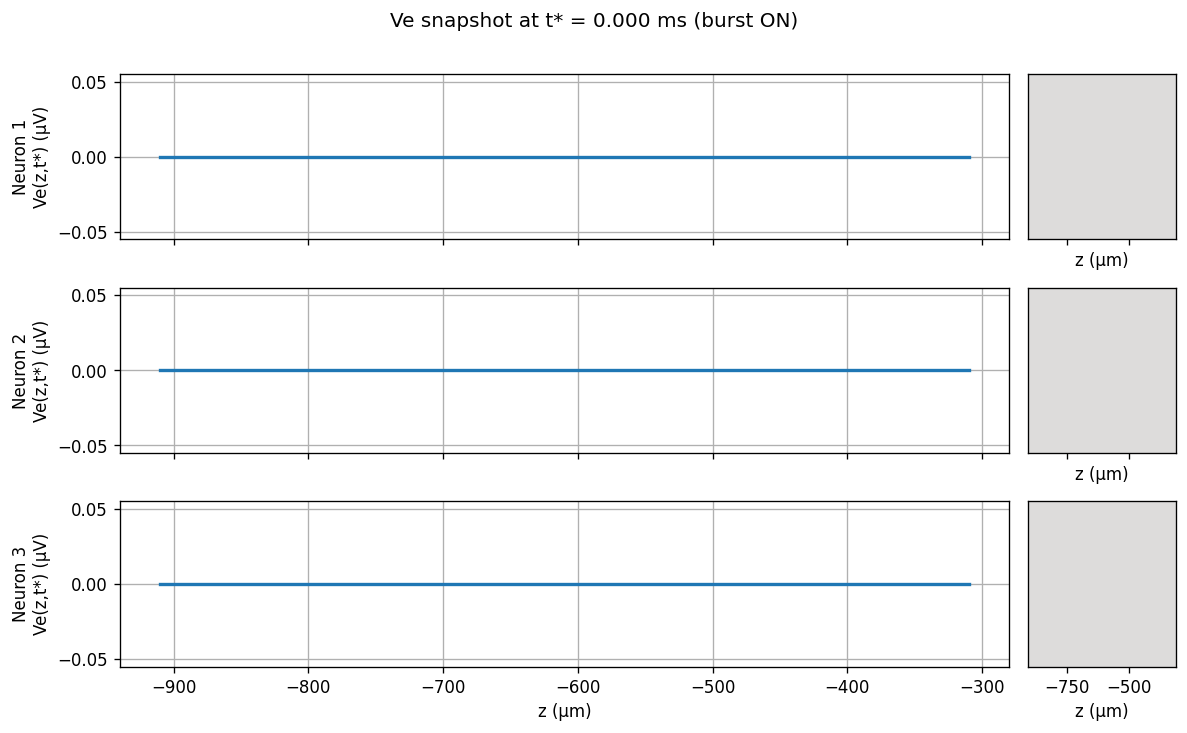

Neuron 1: Ve(t*=0.000 ms) → min = 0.000 µV, max = 0.000 µV, Δ = 0.000 µV
Neuron 2: Ve(t*=0.000 ms) → min = 0.000 µV, max = 0.000 µV, Δ = 0.000 µV
Neuron 3: Ve(t*=0.000 ms) → min = 0.000 µV, max = 0.000 µV, Δ = 0.000 µV


In [ ]:
def nearest_idx(t_array_ms, t_target_ms):
    return int(np.argmin(np.abs(t_array_ms - t_target_ms)))

t_idx_dEdt1 = nearest_idx(t_ms, 0.00)   # dE/dt 최대(1)

plot_Ve_snapshot_heatmaps(all_Ve, t_ms, t_idx_dEdt1)
for i, (xyz, Ve) in enumerate(all_Ve, start=1):
        Ve_snap = Ve[:, t_idx_dEdt1]
        vmax = np.max(Ve_snap)
        vmin = np.min(Ve_snap)
        print(f"Neuron {i}: Ve(t*={t_ms[t_idx_dEdt1]:.3f} ms) → "
              f"min = {vmin*1e6:.3f} µV, max = {vmax*1e6:.3f} µV, "
              f"Δ = {(vmax-vmin)*1e6:.3f} µV")


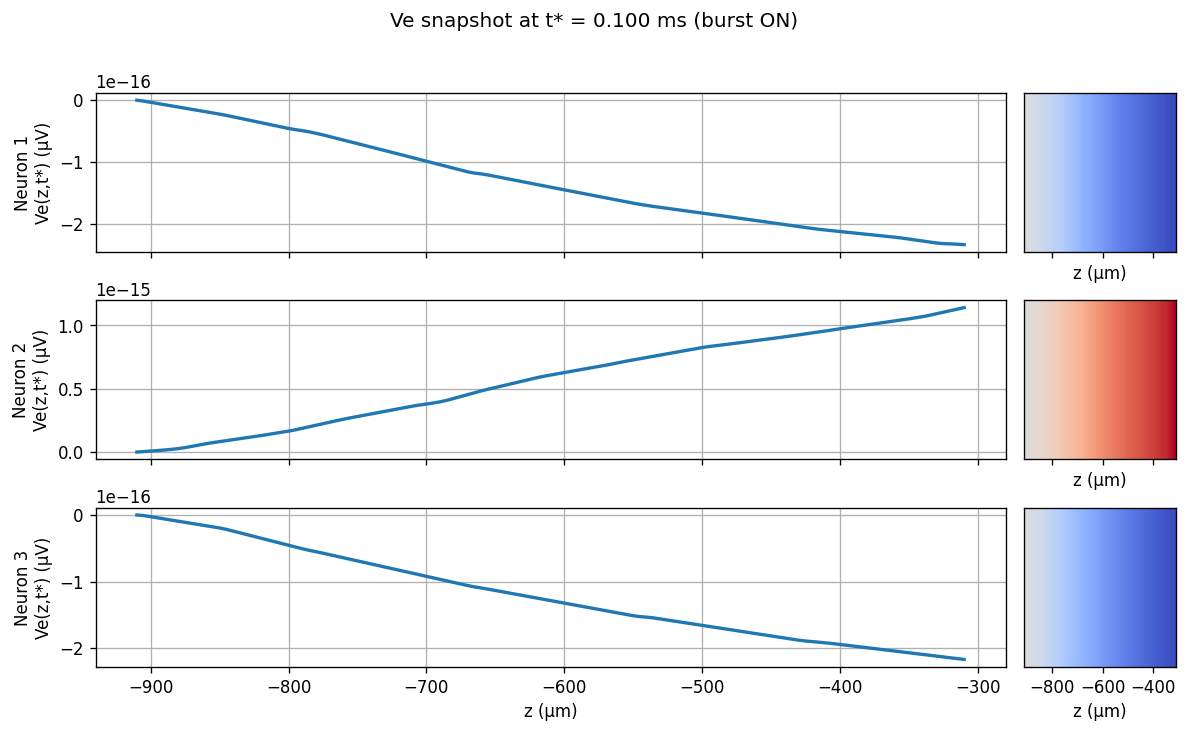

Neuron 1: Ve(t*=0.100 ms) → min = -0.000 µV, max = 0.000 µV, Δ = 0.000 µV
Neuron 2: Ve(t*=0.100 ms) → min = 0.000 µV, max = 0.000 µV, Δ = 0.000 µV
Neuron 3: Ve(t*=0.100 ms) → min = -0.000 µV, max = 0.000 µV, Δ = 0.000 µV


In [ ]:
def nearest_idx(t_array_ms, t_target_ms):
    return int(np.argmin(np.abs(t_array_ms - t_target_ms)))

t_idx_dEdt2 = nearest_idx(t_ms, 0.10)   # dE/dt 최대(2)

# 예: E가 최대인 순간을 찍어보려면
plot_Ve_snapshot_heatmaps(all_Ve, t_ms, t_idx_dEdt2)
for i, (xyz, Ve) in enumerate(all_Ve, start=1):
        Ve_snap = Ve[:, t_idx_dEdt2]
        vmax = np.max(Ve_snap)
        vmin = np.min(Ve_snap)
        print(f"Neuron {i}: Ve(t*={t_ms[t_idx_dEdt2]:.3f} ms) → "
              f"min = {vmin*1e6:.3f} µV, max = {vmax*1e6:.3f} µV, "
              f"Δ = {(vmax-vmin)*1e6:.3f} µV")


In [ ]:
t_idx = np.argmin(np.abs(t_ms - 0.10))
print("wave(t=0.10 ms) =", wave[t_idx])   # → 0 근처여야 정상

wave(t=0.10 ms) = -3.216245299353273e-16


/tmp/ipython-input-957302385.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


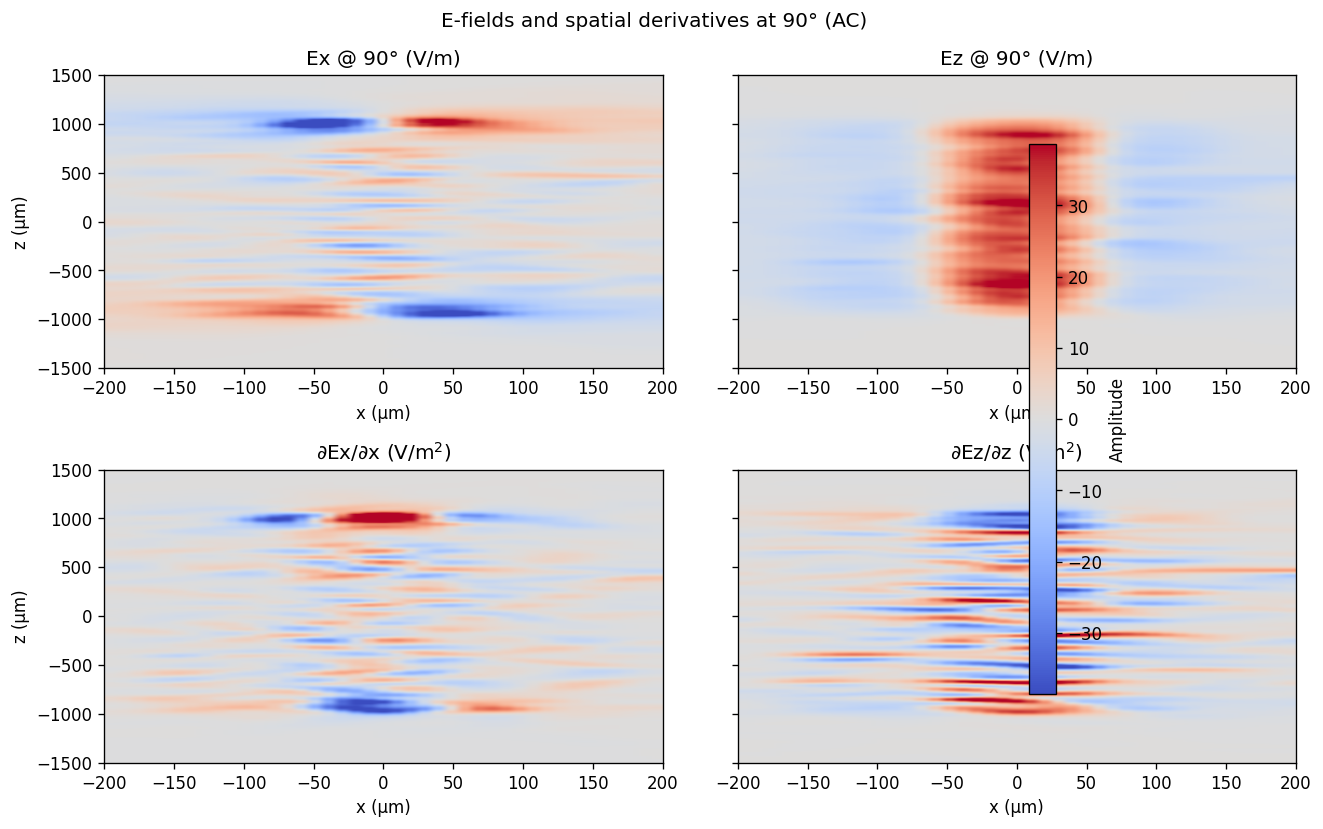

Used grid spacing: dx=10.0 µm, dz=10.0 µm


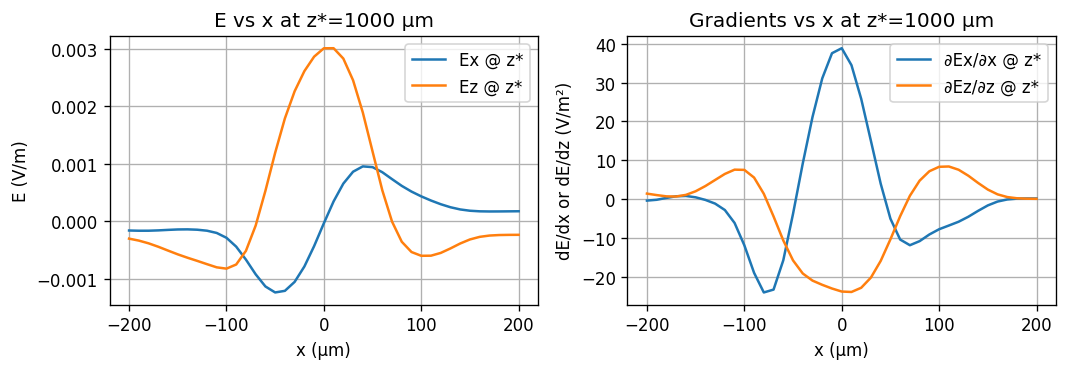

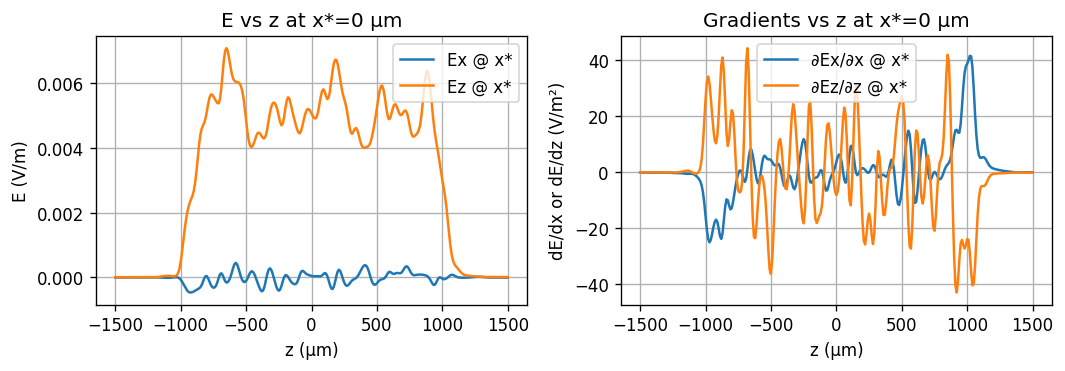

In [ ]:
# =========================
# 7) Activation map (Lee et al. 2016 방식)
#    - E90 = -Imag  (AC 90° 위상)
#    - 활성화 소스 (path가 z축이면):  A(z) = -∂Ez/∂z
#    - 평면 발산(divergence): div E = ∂Ex/∂x + ∂Ez/∂z  (y가 상수 평면일 때)
# =========================

from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata

def build_regular_grid(df, valcol, method='nearest'):
    """
    df: E_im_df (µm, Imag values)
    valcol: 'Ex_im' or 'Ez_im' (we'll flip sign later)
    return: Xs(µm), Zs(µm), M[z,x] (V/m) on regular grid (filled)
    """
    # raw scattered points on a supposed grid
    x = df['x_um'].to_numpy(float)
    z = df['z_um'].to_numpy(float)
    v = df[valcol].to_numpy(float)

    # unique sorted axes
    Xs = np.unique(x)
    Zs = np.unique(z)

    # target grid
    XX, ZZ = np.meshgrid(Xs, Zs)

    # griddata to fill (first linear, then nearest for holes)
    M = griddata(points=np.c_[x, z], values=v, xi=(XX, ZZ), method='linear')
    if np.isnan(M).any():
        M2 = griddata(points=np.c_[x, z], values=v, xi=(XX, ZZ), method='nearest')
        M = np.where(np.isnan(M), M2, M)

    # E90 = -Imag
    return Xs, Zs, -M

def finite_diff(M, dx_m, dz_m):
    """
    M[z,x], spacing in meters -> central differences
    returns: dEx/dx (axis=1), dEz/dz (axis=0) when applied to Ex, Ez respectively
    """
    Gx = np.empty_like(M)   # d/dx
    Gz = np.empty_like(M)   # d/dz

    # axis=1 (x)
    Gx[:,1:-1] = (M[:,2:] - M[:,:-2]) / (2*dx_m)
    Gx[:,0]    = (M[:,1]  - M[:,0])   / dx_m
    Gx[:,-1]   = (M[:,-1] - M[:,-2])  / dx_m

    # axis=0 (z)
    Gz[1:-1,:] = (M[2:,:] - M[:-2,:]) / (2*dz_m)
    Gz[0,:]    = (M[1,:]  - M[0,:])   / dz_m
    Gz[-1,:]   = (M[-1,:] - M[-2,:])  / dz_m

    return Gx, Gz

def p99_sym(A):
    v = np.nanpercentile(np.abs(A), 99.5)
    return (-v, v) if v>0 else (-1, 1)

# --- 1) Build grids for Ex and Ez (90°) ---
Xs, Zs, Ex90 = build_regular_grid(E_im_df, 'Ex_im')
_,  _,  Ez90 = build_regular_grid(E_im_df, 'Ez_im')

# spacing in meters
dx_m = np.mean(np.diff(Xs))*1e-6
dz_m = np.mean(np.diff(Zs))*1e-6

# --- 2) Smooth (sigma=1 grid cell; tune 0.5~2) ---
Ex_s = gaussian_filter(Ex90, sigma=2, mode='nearest')
Ez_s = gaussian_filter(Ez90, sigma=2, mode='nearest')

# --- 3) Derivatives ---
dEx_dx, _     = finite_diff(Ex_s, dx_m, dz_m)   # use Gx for ∂Ex/∂x
_,      dEz_dz= finite_diff(Ez_s, dx_m, dz_m)   # use Gz for ∂Ez/∂z

# --- 4) Clean heatmaps (z,y shared) ---
fig, axs = plt.subplots(2, 2, figsize=(11, 7), sharey=True)

for ax, M, title in [
    (axs[0,0], Ex_s,  r"Ex @ 90° (V/m)"),
    (axs[0,1], Ez_s,  r"Ez @ 90° (V/m)"),
    (axs[1,0], dEx_dx,r"∂Ex/∂x (V/m$^2$)"),
    (axs[1,1], dEz_dz,r"∂Ez/∂z (V/m$^2$)")
]:
    vmin, vmax = p99_sym(M)
    im = ax.imshow(M, origin='lower',
                   extent=[Xs.min(), Xs.max(), Zs.min(), Zs.max()],
                   cmap='coolwarm', vmin=vmin, vmax=vmax, aspect='auto')
    ax.set_title(title); ax.set_xlabel('x (µm)')
axs[0,0].set_ylabel('z (µm)')
axs[1,0].set_ylabel('z (µm)')
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.85, label='Amplitude')
plt.suptitle('E-fields and spatial derivatives at 90° (AC)')
plt.tight_layout(); plt.show()

print(f"Used grid spacing: dx={np.mean(np.diff(Xs)):.1f} µm, dz={np.mean(np.diff(Zs)):.1f} µm")

# --- 5) Line plots (choose either a z* or x*) ---
# pick z* and x* you want
z_star = 1000.0   # µm  (예: 1000)
x_star =    0.0   # µm  (예: 0)

# nearest indices
iz = int(np.argmin(np.abs(Zs - z_star)))
ix = int(np.argmin(np.abs(Xs - x_star)))

# x-scan at z*
plt.figure(figsize=(9,3.2))
plt.subplot(1,2,1)
plt.plot(Xs, Ex_s[iz,:], label='Ex @ z*')
plt.plot(Xs, Ez_s[iz,:], label='Ez @ z*')
plt.xlabel('x (µm)'); plt.ylabel('E (V/m)'); plt.grid(True)
plt.title(f'E vs x at z*={Zs[iz]:.0f} µm'); plt.legend()

plt.subplot(1,2,2)
plt.plot(Xs, dEx_dx[iz,:], label='∂Ex/∂x @ z*')
plt.plot(Xs, dEz_dz[iz,:], label='∂Ez/∂z @ z*')
plt.xlabel('x (µm)'); plt.ylabel('dE/dx or dE/dz (V/m²)'); plt.grid(True)
plt.title(f'Gradients vs x at z*={Zs[iz]:.0f} µm'); plt.legend()
plt.tight_layout(); plt.show()

# z-scan at x*
plt.figure(figsize=(9,3.2))
plt.subplot(1,2,1)
plt.plot(Zs, Ex_s[:,ix], label='Ex @ x*')
plt.plot(Zs, Ez_s[:,ix], label='Ez @ x*')
plt.xlabel('z (µm)'); plt.ylabel('E (V/m)'); plt.grid(True)
plt.title(f'E vs z at x*={Xs[ix]:.0f} µm'); plt.legend()

plt.subplot(1,2,2)
plt.plot(Zs, dEx_dx[:,ix], label='∂Ex/∂x @ x*')
plt.plot(Zs, dEz_dz[:,ix], label='∂Ez/∂z @ x*')
plt.xlabel('z (µm)'); plt.ylabel('dE/dx or dE/dz (V/m²)'); plt.grid(True)
plt.title(f'Gradients vs z at x*={Xs[ix]:.0f} µm'); plt.legend()
plt.tight_layout(); plt.show()

활성화 threshold ≈ 24.905 V/m² (|∂Ez/∂z| > thr)


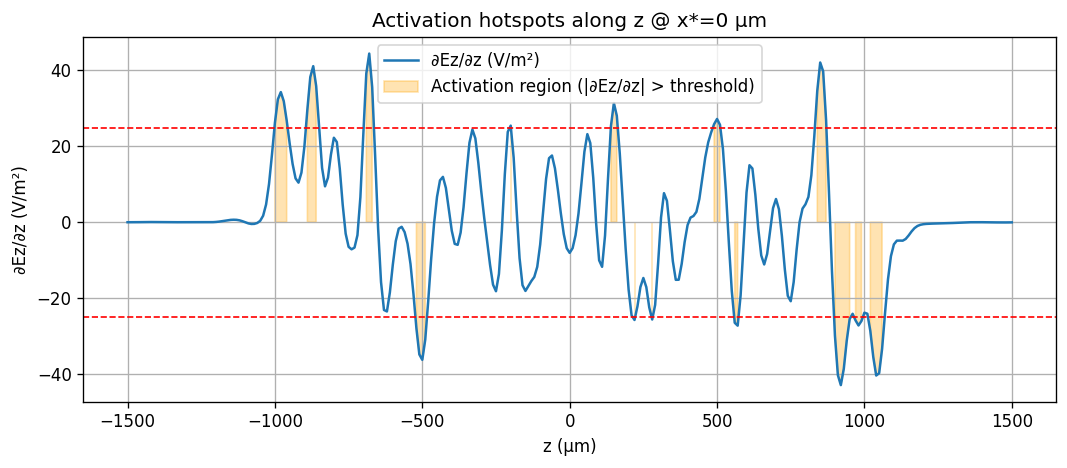

🔹 활성 구간 개수: 45 포인트
   z-range ≈ -1000 ~ 1060 µm


In [ ]:
# 기준값: gradient의 RMS 또는 70~90 percentile 정도 사용
thr = np.percentile(np.abs(dEz_dz[:, ix]), 85)  # 상위 15% 구간 기준
print(f"활성화 threshold ≈ {thr:.3f} V/m² (|∂Ez/∂z| > thr)")

# z좌표와 gradient 데이터 준비
z_vals = Zs
grad = dEz_dz[:, ix]

# 활성화 구간 찾기
mask = np.abs(grad) > thr
active_z = z_vals[mask]

plt.figure(figsize=(9,4))
plt.plot(z_vals, grad, label="∂Ez/∂z (V/m²)")
plt.fill_between(z_vals, grad, 0, where=mask, color='orange', alpha=0.3,
                 label='Activation region (|∂Ez/∂z| > threshold)')
plt.axhline(thr, color='r', ls='--', lw=1)
plt.axhline(-thr, color='r', ls='--', lw=1)
plt.xlabel("z (µm)"); plt.ylabel("∂Ez/∂z (V/m²)")
plt.title(f"Activation hotspots along z @ x*={Xs[ix]:.0f} µm")
plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# 요약 출력
if active_z.size > 0:
    print(f"🔹 활성 구간 개수: {np.sum(mask)} 포인트")
    print(f"   z-range ≈ {active_z.min():.0f} ~ {active_z.max():.0f} µm")
else:
    print("⚠️ 활성 구간이 threshold 기준을 넘지 않습니다.")

Xs range: -200.00 ~ 200.00 µm
Zs range: -1500.00 ~ 1500.00 µm
Mean Δx = 10.000 µm, std = 1.815e-14
Mean Δz = 10.000 µm, std = 1.012e-13


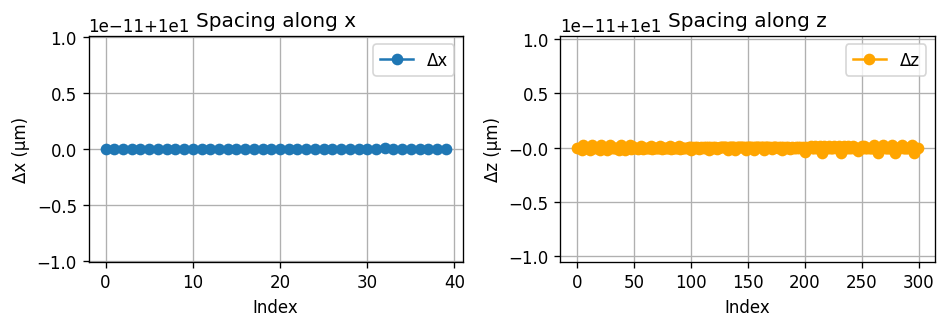

In [ ]:
# === Check grid uniformity ===
dxs = np.diff(Xs)
dzs = np.diff(Zs)

print(f"Xs range: {Xs.min():.2f} ~ {Xs.max():.2f} µm")
print(f"Zs range: {Zs.min():.2f} ~ {Zs.max():.2f} µm")

print(f"Mean Δx = {np.mean(dxs):.3f} µm, std = {np.std(dxs):.3e}")
print(f"Mean Δz = {np.mean(dzs):.3f} µm, std = {np.std(dzs):.3e}")

# 시각적으로도 확인
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(dxs, 'o-', label='Δx')
plt.xlabel('Index'); plt.ylabel('Δx (µm)')
plt.title('Spacing along x'); plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.plot(dzs, 'o-', label='Δz', color='orange')
plt.xlabel('Index'); plt.ylabel('Δz (µm)')
plt.title('Spacing along z'); plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()
